In [15]:
#pip install researchpy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import researchpy
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
#loading data into dataframe and summarize basic statistics over all columns
tumor_df = pd.read_csv("./tumor_dataset.csv")
researchpy.summarize(tumor_df, stats=["N", "Mean", "Median", "Variance", "SD", "SE", "CI", "Min", "Max", "Range", "Kurtosis", "Skew"])

,Name,N,Mean,Median,Variance,SD,SE,95% Conf. Interval,Min,Max,Range,Kurtosis,Skew
0,Sample code number,683,1076720.2269,1171795.0,385199033889.421997,620644.0477,23748.2845,Sample code number,63375,13454352,13390977.0,258.4794,13.7182
1,Clump Thickness,683,4.4422,4.0,7.9567,2.8208,0.1079,Clump Thickness,1,10,9.0,2.3627,0.5864
2,Uniformity of Cell Size,683,3.1508,1.0,9.3951,3.0651,0.1173,Uniformity of Cell Size,1,10,9.0,3.0644,1.2237
3,Uniformity of Cell Shape,683,3.2152,1.0,8.9316,2.9886,0.1144,Uniformity of Cell Shape,1,10,9.0,2.9745,1.1553
4,Marginal Adhesion,683,2.8302,1.0,8.2057,2.8646,0.1096,Marginal Adhesion,1,10,9.0,3.9268,1.5059
5,Single Epithelial Cell Size,683,3.2343,2.0,4.9421,2.2231,0.0851,Single Epithelial Cell Size,1,10,9.0,5.1053,1.7
6,Bare Nuclei,683,3.5447,1.0,13.2777,3.6439,0.1394,Bare Nuclei,1,10,9.0,2.1982,0.9878
7,Bland Chromatin,683,3.4451,3.0,6.001,2.4497,0.0937,Bland Chromatin,1,10,9.0,3.1576,1.0929
8,Normal Nucleoli,683,2.8697,1.0,9.3188,3.0527,0.1168,Normal Nucleoli,1,10,9.0,3.4614,1.4173
9,Mitoses,683,1.6032,1.0,3.0022,1.7327,0.0663,Mitoses,1,10,9.0,15.1749,3.5038


In [3]:
#Checking for missing values
tumor_df.isnull().any()

Sample code number             False
Clump Thickness                False
Uniformity of Cell Size        False
Uniformity of Cell Shape       False
Marginal Adhesion              False
Single Epithelial Cell Size    False
Bare Nuclei                    False
Bland Chromatin                False
Normal Nucleoli                False
Mitoses                        False
Class                          False
dtype: bool

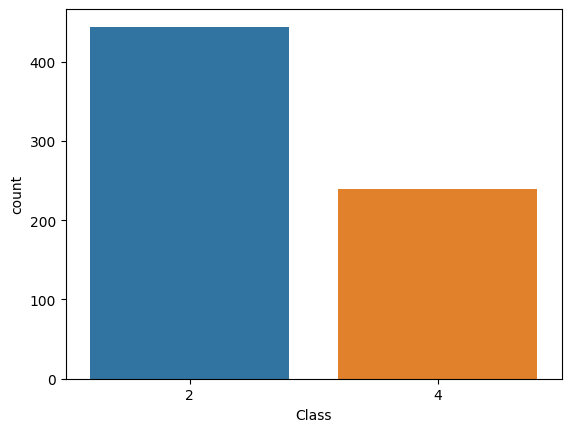

In [9]:
#Check Class distribution
sns.countplot(tumor_df, x="Class", );

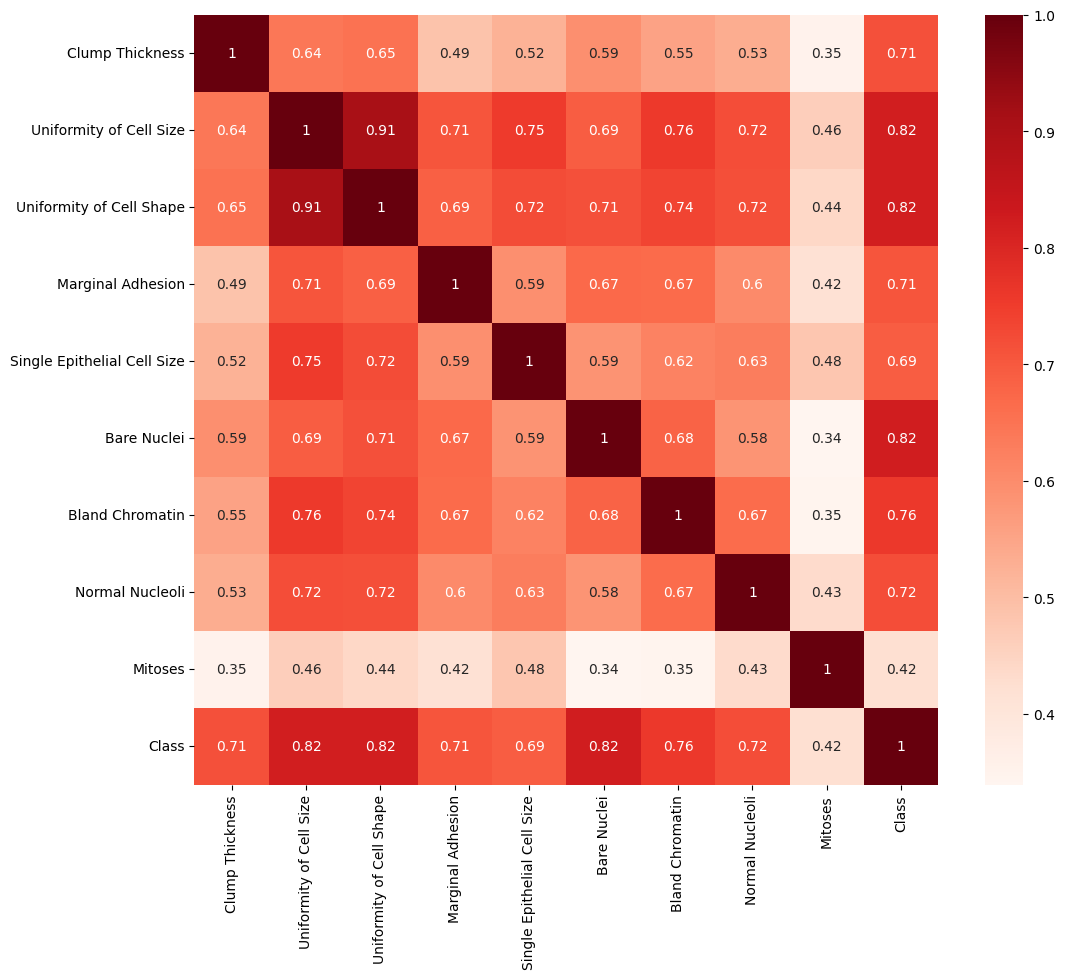

In [55]:
#Finding correlated features
plt.figure(figsize=(12,10))
cor = tumor_df.iloc[:,1:].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

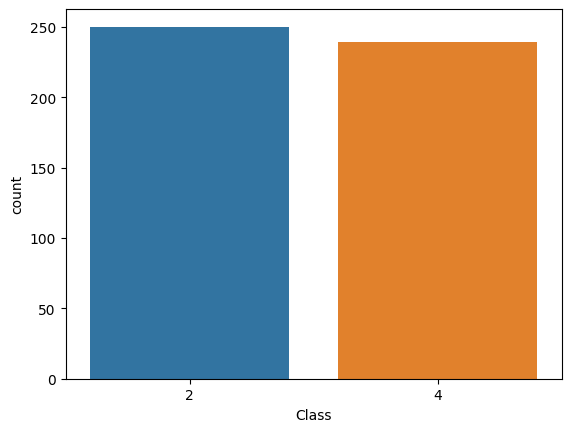

In [17]:
#Under-Sample the Majority Class (2 = benign)
UnderSampleClass = tumor_df.loc[tumor_df["Class"] == 2]
UnderSampleClass_Sample = UnderSampleClass.sample(250)

#Merge two class sets
Only4Class = tumor_df.loc[tumor_df["Class"] == 4]
tumor_df_Merged = pd.concat([Only4Class,UnderSampleClass_Sample])

#Recheck distribution
sns.countplot(tumor_df_Merged, x="Class", );

In [18]:
#Splitting the data into training (~80%), validation (~10%) and test (~10%) data
x_columns = ["Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape", "Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin", "Normal Nucleoli", "Mitoses"]
y_column = ["Class"]
X = tumor_df_Merged[x_columns]
y = tumor_df_Merged[y_column]

#Transform 2 (for benign) into "No" (0) and 4 (for malignant) into "Yes" (1)
y = y.replace({'Class': {2: "No", 4: "Yes"}})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

In [21]:
#Finding the best configuration settings using gradient decent using the validation set to tune hyperparameters
max_depth = [ x for x in range(1,16)]

settings = []

for criterion in ['entropy', 'log_loss', 'gini']:
    for eta0 in max_depth:
        model = DecisionTreeClassifier(criterion=criterion, max_depth=eta0, random_state=101)
        model.fit(X_train,y_train)
        accuracy = sklearn.metrics.accuracy_score(y_val, model.predict(X_val))
        settings.append((criterion, eta0, accuracy))

# for config in settings:
#     print(config)

best_accuracy =  max(settings, key=lambda x: x[-1])
print("Best settings according to Accuracy {}".format(best_accuracy))

Best settings according to Accuracy ('gini', 6, 0.9772727272727273)


In [22]:
#Applying best settings to the test set
criterion, max_depth = best_accuracy[:2] 
model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=101)
model.fit(X_train,y_train)
y_pred_test = model.predict(X_test)
accuracy_score_test = sklearn.metrics.accuracy_score(y_test, y_pred_test)
print(accuracy_score_test)

0.9591836734693877


In [23]:
#Display each feature importance
feat_importance = pd.DataFrame(model.feature_importances_, index=x_columns, columns=["Values"])
feat_importance.sort_values(by=["Values"], ascending=False)

,Values
Uniformity of Cell Size,0.807314
Clump Thickness,0.068762
Bare Nuclei,0.065432
Normal Nucleoli,0.020280
Uniformity of Cell Shape,0.014123
Marginal Adhesion,0.009557
Single Epithelial Cell Size,0.008192
Bland Chromatin,0.006339
Mitoses,0.000000


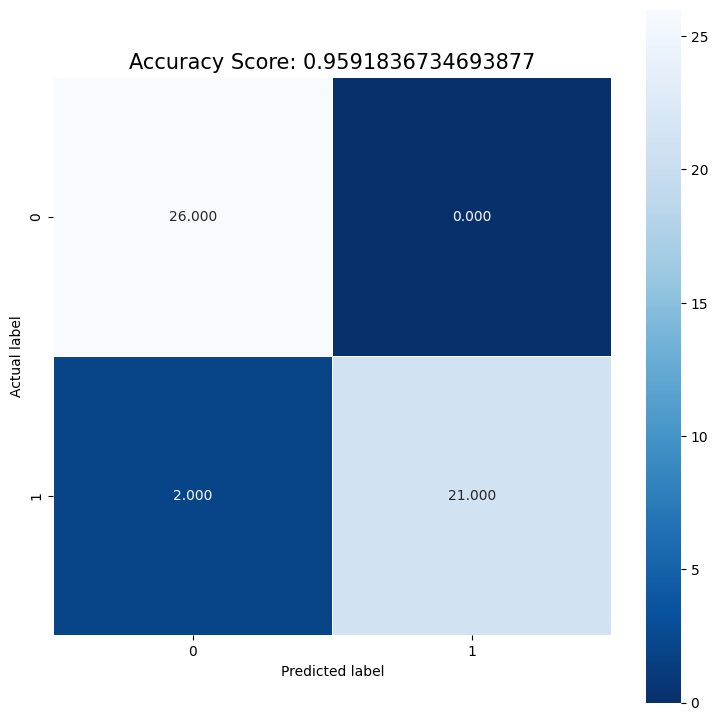

In [24]:
#Visualizing confusion matrix
cm = sklearn.metrics.confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score_test)
plt.title(all_sample_title, size = 15);

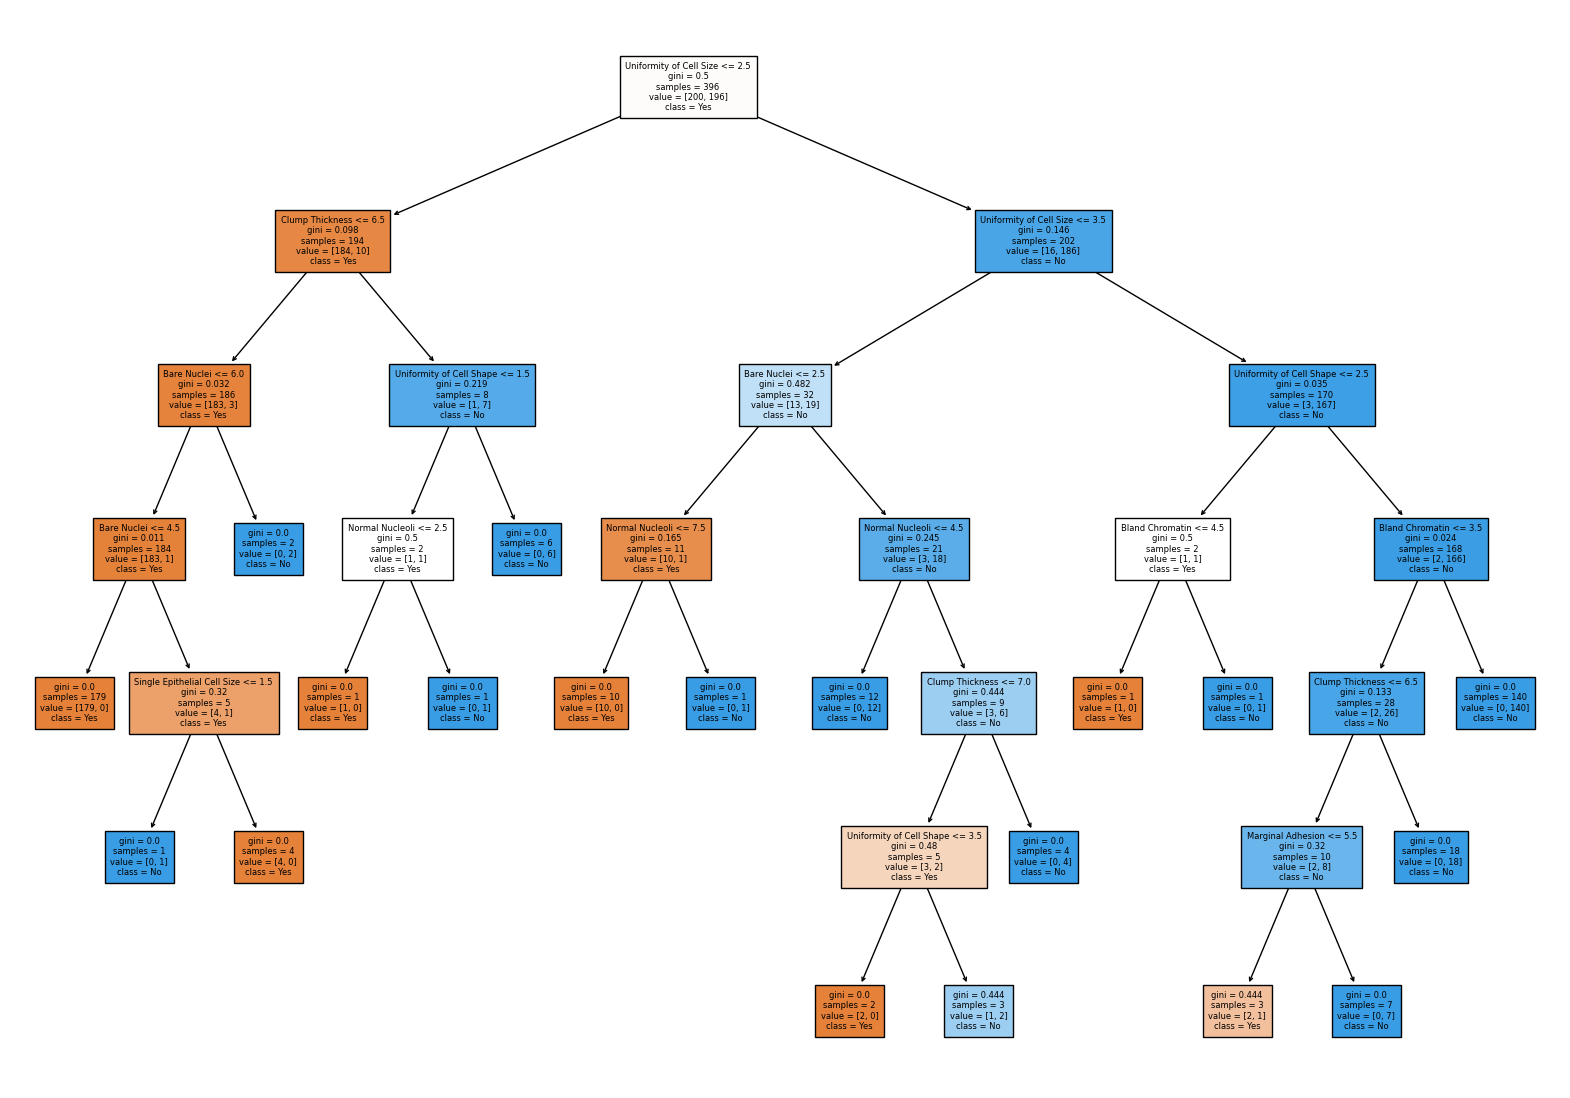

In [27]:
#Visualizing the final decision tree
y_class_names = ["Yes","No"]

fig = plt.figure(figsize=(20,14)) #20,20
_ = plot_tree(model, 
            feature_names=x_columns,  
            class_names=y_class_names,
            fontsize=6,
            filled=True)